In [128]:
import pointcloud
import numpy as np

In [129]:
pc = pointcloud.PointCloud()
pc.read_from_file('gh16.ptx')

In [191]:
def plot_3d_points(points, **kwargs):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.axes3d import Axes3D

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    x, y, z = zip(*points)

    ax.scatter(x, y, z, **kwargs)
    ax.view_init(150, 45)

    plt.show()

def get_rotation_matrix(theta_x, theta_y, theta_z):
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theta_x), -np.sin(theta_x)],
        [0, np.sin(theta_x), np.cos(theta_x)],
    ])

    Ry = np.array([
        [np.cos(theta_y), 0, np.sin(theta_y)],
        [0, 1, 0],
        [-np.sin(theta_y), 0, np.cos(theta_y)],
    ])

    Rz = np.array([
        [np.cos(theta_z), -np.sin(theta_z), 0],
        [np.sin(theta_z), np.cos(theta_z), 0],
        [0, 0, 1],
    ])
    
    return np.matmul(np.matmul(Rz, Ry), Rx)

def get_translation_vector(dx, dy, dz):
    return np.array([dx, dy, dz])

def get_homogeneous_transformation(rx, ry, rz, dx, dy, dz):
    ht = np.identity(4)
    ht[:3, :3] = get_rotation_matrix(rx, ry, rz)
    ht[:3, 3] = get_translation_vector(dx, dy, dz)
    
    return ht

def make_homogeneous_points(points):
    return np.concatenate([points, np.ones((points.shape[0], 1))], axis=1)

def least_square_approximation(x, b):
    return np.matmul(np.matmul(b, x.transpose()), np.linalg.inv(np.matmul(x, x.transpose())))

In [192]:
sampling_rate = 30
sampled_points = pc.points.reshape((pc.nrows*pc.ncols, 3))[::sampling_rate]
points = sampled_points[np.any(sampled_points, axis=1)]

In [193]:
transform = get_homogeneous_transformation(0.1, 0.1, 0.1, 2, -4, 3)

x = make_homogeneous_points(points).transpose()
b = np.matmul(transform, x)

A = least_square_approximation(x, b)

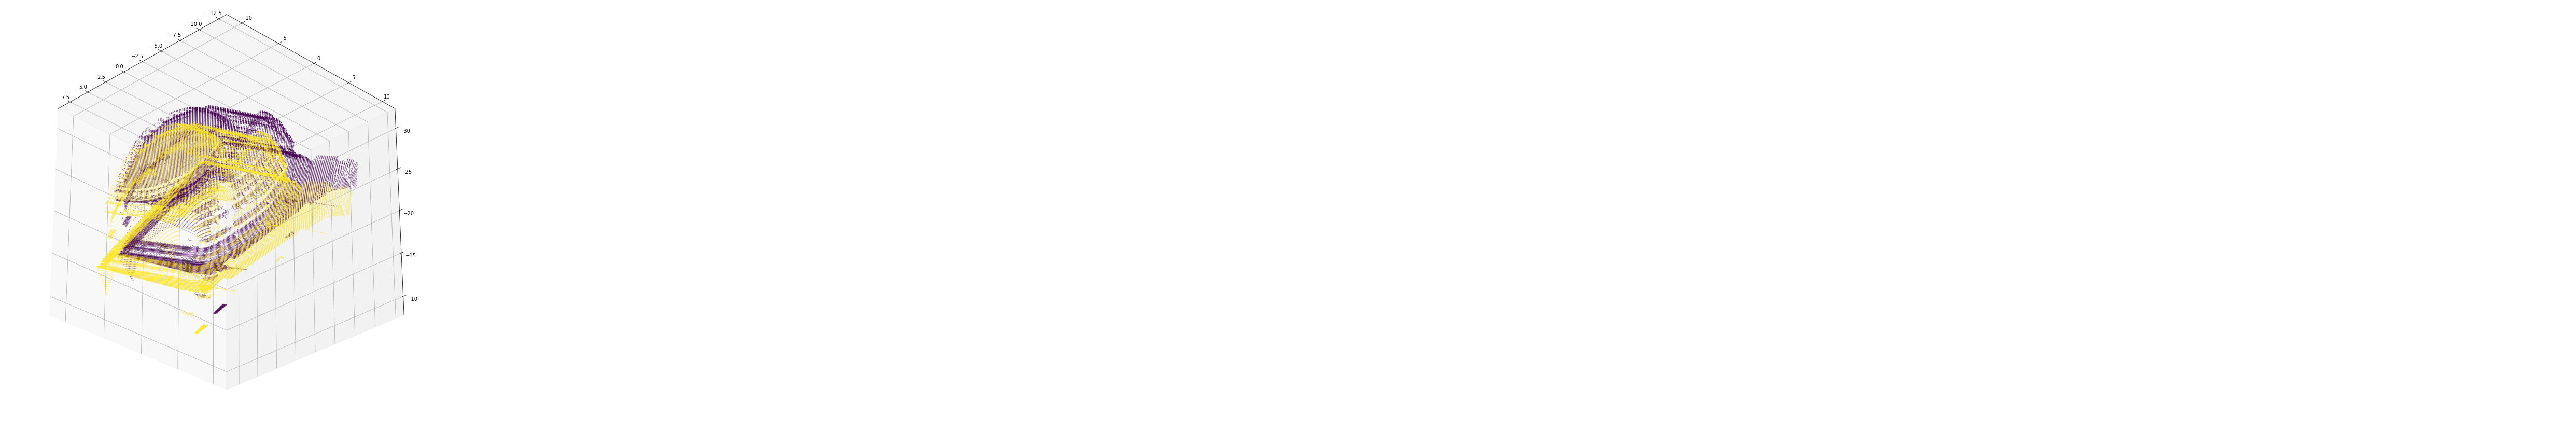

In [198]:
n = points.shape[0]
labels = np.concatenate([np.zeros(n), np.ones(n)])

mix = np.concatenate([points, b.transpose()[:, :3]], axis=0)
plot_3d_points(mix, c=labels, alpha=0.4, s=1)

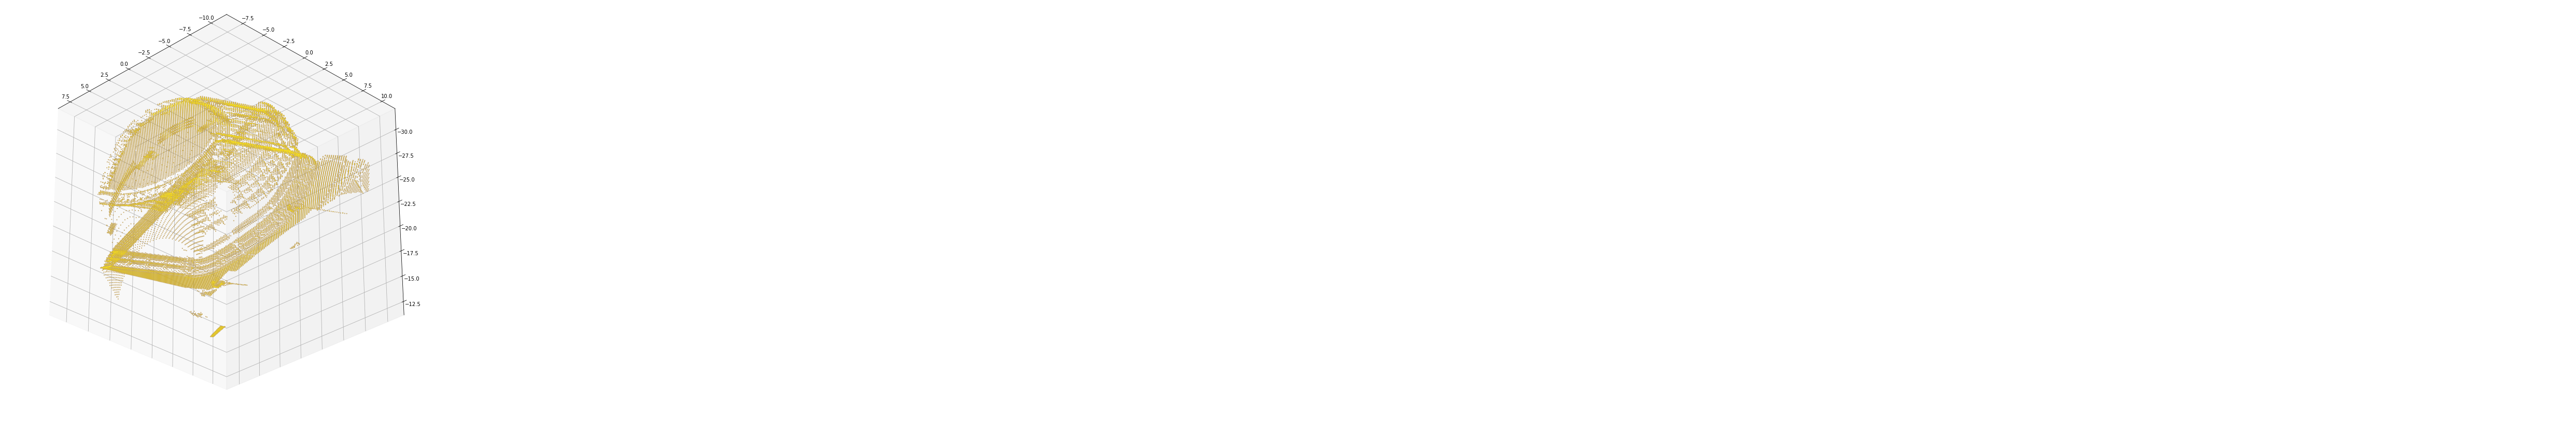

In [199]:
n = points.shape[0]
labels = np.concatenate([np.zeros(n), np.ones(n)])

new_points = np.matmul(np.linalg.inv(A), b).transpose()

mix = np.concatenate([points, new_points[:, :3]], axis=0)
plot_3d_points(mix, c=labels, alpha=0.4, s=1)